# Fine tuning with S-BERT

### Implementing the callback functions while training + k-fold cross validation

The models will have saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing



In [ ]:
'''
installing some extra libraries
'''

! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg


from google.colab import drive
drive.mount('/content/drive')

'''
runtime restart is required for the libraries to be active in the notebook
'''

import os
os.kill(os.getpid(), 9)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g59ArDf-raMSikn-sNvUBVQxvRHpJtwJ-qsYnafAd08QpxJXLg5f0w


In [1]:
import spacy

if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


In [1]:
!rm -rf policy-data-analyzer/

# Define branch to clone
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (255/255), done.
remote: Total 5367 (delta 456), reused 666 (delta 437), pack-reused 4674
Receiving objects: 100% (5367/5367), 204.07 MiB | 31.11 MiB/s, done.
Resolving deltas: 100% (2767/2767), done.
Checking out files: 100% (1113/1113), done.


### For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
'''
importing all the required Python packages
importing modules from the GitHub repository as well
'''

import math, time
from typing import Iterable, Dict, Tuple, Type, Callable
import pandas as pd
import sys, os, csv, json

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.metrics import classification_report
import transformers
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from torch.utils.data import DataLoader
import cupy as cp
import cupy as cp
import spacy

from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample
from sentence_transformers.evaluation import LabelAccuracyEvaluator, SentenceEvaluator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.optim import Optimizer
from torch.utils.data import DataLoader

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error

from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_loading.src.utils import *
from tasks.model_evaluation.src.model_evaluator import *
from tasks.data_augmentation.src.zero_shot_classification.fine_tuning_sbert import *
from tasks.data_visualization.src.plotting import *

Using the GPU


In [3]:
'''
defining a custom head Linear layer
'''

class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

In [4]:
"""
Refactoring the sentence transformer model.fit() function for our purpose here
Implementing the Early Stopping feature that will be useful for us

Original source code: https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/SentenceTransformer.py#L434
"""

import torch
from torch import device
import torch.multiprocessing as mp
from tqdm.autonotebook import trange
import queue
from statistics import mean

class SentenceTransformer(SentenceTransformer): # I checked and I think the same name will work when overriding the fit function

    def fit(self,
            train_objectives: Iterable[Tuple[DataLoader, nn.Module]],
            evaluator: SentenceEvaluator = None,
            epochs: int = 1,
            steps_per_epoch = None,
            scheduler: str = 'WarmupLinear',
            warmup_steps: int = 10000,
            optimizer_class: Type[Optimizer] = transformers.AdamW,
            optimizer_params : Dict[str, object]= {'lr': 2e-5},
            weight_decay: float = 0.01,
            evaluation_steps: int = 0,
            output_path: str = None,
            save_best_model: bool = True,
            max_grad_norm: float = 1,
            use_amp: bool = False,
            callback: Callable[[float, int, int], None] = None,
            show_progress_bar: bool = True,
            BASELINE: float = 0.01,
            PATIENCE: int = 5
            ):
        """
        Train the model with the given training objective
        Each training objective is sampled in turn for one batch.
        We sample only as many batches from each objective as there are in the smallest one
        to make sure of equal training with each dataset.
        :param train_objectives: Tuples of (DataLoader, LossFunction). Pass more than one for multi-task learning
        :param evaluator: An evaluator (sentence_transformers.evaluation) evaluates the model performance during training on held-out dev data. It is used to determine the best model that is saved to disc.
        :param epochs: Number of epochs for training
        :param steps_per_epoch: Number of training steps per epoch. If set to None (default), one epoch is equal the DataLoader size from train_objectives.
        :param scheduler: Learning rate scheduler. Available schedulers: constantlr, warmupconstant, warmuplinear, warmupcosine, warmupcosinewithhardrestarts
        :param warmup_steps: Behavior depends on the scheduler. For WarmupLinear (default), the learning rate is increased from o up to the maximal learning rate. After these many training steps, the learning rate is decreased linearly back to zero.
        :param optimizer_class: Optimizer
        :param optimizer_params: Optimizer parameters
        :param weight_decay: Weight decay for model parameters
        :param evaluation_steps: If > 0, evaluate the model using evaluator after each number of training steps
        :param output_path: Storage path for the model and evaluation files
        :param save_best_model: If true, the best model (according to evaluator) is stored at output_path
        :param max_grad_norm: Used for gradient normalization.
        :param use_amp: Use Automatic Mixed Precision (AMP). Only for Pytorch >= 1.6.0
        :param callback: Callback function that is invoked after each evaluation.
                It must accept the following three parameters in this order:
                `score`, `epoch`, `steps`
        :param show_progress_bar: If True, output a tqdm progress bar
        :param BASELINE: minimum improvement in the accuracy for a new model to be saved and best_score to be updated
        :param PATIENCE: maximum number of epochs to go without an improvement in the accuracy
        """
        self.ACC_LIST = [1e-6] # stores the accuracy while training

        self.BASELINE = BASELINE
        self.PATIENCE = PATIENCE

        if use_amp:
            from torch.cuda.amp import autocast
            scaler = torch.cuda.amp.GradScaler()

        self.to(self._target_device)

        if output_path is not None:
            os.makedirs(output_path, exist_ok=True)

        dataloaders = [dataloader for dataloader, _ in train_objectives]

        # Use smart batching
        for dataloader in dataloaders:
            dataloader.collate_fn = self.smart_batching_collate

        loss_models = [loss for _, loss in train_objectives]
        for loss_model in loss_models:
            loss_model.to(self._target_device)

        self.best_score = -9999999

        if steps_per_epoch is None or steps_per_epoch == 0:
            steps_per_epoch = min([len(dataloader) for dataloader in dataloaders])

        num_train_steps = int(steps_per_epoch * epochs)

        # Prepare optimizers
        optimizers = []
        schedulers = []
        for loss_model in loss_models:
            param_optimizer = list(loss_model.named_parameters())

            no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
            optimizer_grouped_parameters = [
                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
            ]

            optimizer = optimizer_class(optimizer_grouped_parameters, **optimizer_params)
            scheduler_obj = self._get_scheduler(optimizer, scheduler=scheduler, warmup_steps=warmup_steps, t_total=num_train_steps)

            optimizers.append(optimizer)
            schedulers.append(scheduler_obj)


        global_step = 0
        data_iterators = [iter(dataloader) for dataloader in dataloaders]

        num_train_objectives = len(train_objectives)

        skip_scheduler = False
        for epoch in trange(epochs, desc="Epoch", disable=not show_progress_bar):
            training_steps = 0

            for loss_model in loss_models:
                loss_model.zero_grad()
                loss_model.train()

            for _ in trange(steps_per_epoch, desc="Iteration", smoothing=0.05, disable=not show_progress_bar):
                for train_idx in range(num_train_objectives):
                    loss_model = loss_models[train_idx]
                    optimizer = optimizers[train_idx]
                    scheduler = schedulers[train_idx]
                    data_iterator = data_iterators[train_idx]

                    try:
                        data = next(data_iterator)
                    except StopIteration:
                        data_iterator = iter(dataloaders[train_idx])
                        data_iterators[train_idx] = data_iterator
                        data = next(data_iterator)


                    features, labels = data


                    if use_amp:
                        with autocast():
                            loss_value = loss_model(features, labels)

                        scale_before_step = scaler.get_scale()
                        scaler.scale(loss_value).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(loss_model.parameters(), max_grad_norm)
                        scaler.step(optimizer)
                        scaler.update()

                        skip_scheduler = scaler.get_scale() != scale_before_step
                    else:
                        loss_value = loss_model(features, labels)
                        loss_value.backward()
                        torch.nn.utils.clip_grad_norm_(loss_model.parameters(), max_grad_norm)
                        optimizer.step()

                    optimizer.zero_grad()

                    if not skip_scheduler:
                        scheduler.step()

                training_steps += 1
                global_step += 1

                if evaluation_steps > 0 and training_steps % evaluation_steps == 0:
                    for loss_model in loss_models:
                        loss_model.zero_grad()
                        loss_model.train()

            flag = self._eval_during_training(evaluator, output_path, save_best_model, epoch, -1, callback)
            if flag is False:
                print('TRAINING EXITED. Best model has been found.')
                print(f'Epoch: {epoch}')
                print(f"Best score: {self.best_score}")
                print('='*60)
                plt.plot(self.ACC_LIST)
                plt.show()
                return
            else:
                print(f'Epoch: {epoch}')
                print(f"Best score: {self.best_score}")
                print('='*60)
            
            # removing the unnecessary first element in ACC_LIST that needed to be there for epoch 1
            if epoch == 0:
                del self.ACC_LIST[0]
                
        if evaluator is None and output_path is not None:   #No evaluator, but output path: save final model version
            self.save(output_path)
    
    def _eval_during_training(self, evaluator, output_path, save_best_model, epoch, steps, callback):
        """Runs evaluation during the training"""

        if evaluator is not None:
            score = evaluator(self, output_path=output_path, epoch=epoch, steps=steps)

            self.ACC_LIST.append(score)

            prev_score = self.ACC_LIST[-2]
            moving_average = mean(self.ACC_LIST[-self.PATIENCE-1: -1])

            print(
            f'''{'='*60}\nCurrent Score is: {score}\nCurrent ACC_LIST is: {self.ACC_LIST}
            '''
            )
            
            if score >= moving_average or len(self.ACC_LIST) - 1 <= self.PATIENCE: # score is >= the moving average in the last PATIENCE values
                if score > prev_score and score - prev_score >= self.BASELINE: # better score 
                    if score > self.best_score: # checking for local maxima
                        self.best_score = score
                        self.save(output_path)
                    return True # continue training whether this is local maxima or not
                elif score >= prev_score and score - prev_score < self.BASELINE:
                    if score > self.best_score: # checking for local maxima
                        self.best_score = score
                        self.save(output_path)
                    return False # end training whether this is local maxima or not, no more training happening after this plateau
                else:
                    # if current score < previous score
                    return True # do not save the model but continue training
            else:
                print(f'Current score ({score}) less than moving average ({moving_average})')
                return False # if this accuracy is less than moving average, we do not want to save the weights of this epoch

In [5]:
'''
define training functions
'''

def grid_search_fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names,
                                eval_classifier=None):
    """
    This function finds the optimal model with fine tuning
    """
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    all_test_perc = train_params["all_test_perc"]
    model_names = train_params["model_names"]
    max_num_epochs = train_params["max_num_epochs"]
    baseline = train_params['baseline']
    patience = train_params['patience']

    numeric_labels = labels2numeric(test_labels, label_names)
    
    if eval_classifier is None:
        train_params["eval_classifier"] = "SBERT"
    else:
        train_params["eval_classifier"] = eval_classifier.__class__.__name__
    
    print(f"Grid Search Fine tuning parameters:\n{json.dumps(train_params, indent=4)}")

    json_output_fname = output_path + f"/{experiment}_FineTuningResults.json"

    # Output setup - we will update the json as the fine tuning process goes so every result is stored immediately
    with open(json_output_fname, "w") as f:
        json.dump({}, f)

    for test_perc in all_test_perc:
        with open(json_output_fname, "r") as fr:
            output = json.load(fr)

        output[f"test_perc={test_perc}"] = {}
        X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                            stratify=train_labels, random_state=100)

        # Load data samples into batches
        train_batch_size = 16
        label2int = dict(zip(label_names, range(len(label_names))))
        train_samples = []
        for sent, label in zip(X_train, y_train):
            label_id = label2int[label]
            train_samples.append(InputExample(texts=[sent], label=label_id))

        # Configure the dev set evaluator - still need to test whether this works
        dev_samples = []
        for sent, label in zip(X_test, y_test):
            label_id = label2int[label]
            dev_samples.append(InputExample(texts=[sent], label=label_id))

        for model_name in model_names:
            # Setup
            output[f"test_perc={test_perc}"][model_name] = []

            # Train set config
            model = SentenceTransformer(model_name)
            train_dataset = SentencesDataset(train_samples, model=model)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

            # Define the way the loss is computed
            classifier = SoftmaxClassifier(model=model,
                                           sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                           num_labels=len(label2int))

            # Dev set config
            dev_dataset = SentencesDataset(dev_samples, model=model)
            dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
            dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')

            # we don't need to loop over epochs anymore since that is not a hyperparameter
            warmup_steps = math.ceil(
                len(train_dataset) * max_num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
            
            model_deets = f"{train_params['eval_classifier']}_model={model_name}_test-perc={test_perc}_n-epoch={max_num_epochs}"
            
            # Train the model
            start = time.time()

            model.fit(train_objectives=[(train_dataloader, classifier)],
                        evaluator=dev_evaluator,
                        epochs=max_num_epochs,  # We always tune on an extra epoch to see the performance gain
                        evaluation_steps=1000,
                        warmup_steps=warmup_steps,
                        output_path=output_path
                        # BASELINE=baseline,
                        # PATIENCE=patience
                        )

            end = time.time()
            hours, rem = divmod(end - start, 3600)
            minutes, seconds = divmod(rem, 60)
            print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

            if eval_classifier is None:
                evaluate_using_sbert(model, test_sents, test_labels, label_names,
                                        model_deets, model_name, max_num_epochs, numeric_labels, output,
                                        output_path, test_perc, json_output_fname)
            else:
                evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents,
                                        test_labels, label_names, model_deets, model_name, max_num_epochs,
                                        output, test_perc, output_path, json_output_fname)


def evaluate_using_sbert(model, test_sents, test_labels, label_names,
                         model_deets, model_name, num_epochs, numeric_labels, output,
                         output_path, test_perc, json_output_fname):
    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
    test_embs = encode_all_sents(test_sents, model, proj_matrix)
    label_embs = encode_labels(label_names, model, proj_matrix)
    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")
    model_preds, model_scores = calc_all_cos_similarity(test_embs, label_embs, label_names)

    print("Evaluating predictions...")
    numeric_preds = labels2numeric(model_preds, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_labels, y_pred=numeric_preds)
    output[f"test_perc={test_perc}"][model_name].append(
        {"num_epochs": num_epochs,
         "avg_f1": evaluator.avg_f1.tolist()})

    with open(json_output_fname, "w") as f:
        json.dump(output, f)
    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())


def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, model_deets, model_name, num_epochs, output,
                           test_perc, output_path, json_output_fname):
    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    output[f"test_perc={test_perc}"][model_name].append({"num_epochs": num_epochs, "avg_f1": evaluator.avg_f1.tolist()})
    with open(json_output_fname, "w") as f:
        json.dump(output, f)

    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

# Data Loading

In [6]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 3

In [7]:
experiment = "EXP30"
classifier = "Binary"

base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/\
                                {classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}/"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment #{GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)
# plot_data_distribution(numeric_train_labels, label_names)
# print("Train Sentence:", train_sents[2], "\nTrain Label:", train_labels[2])
# print("Test Sentence:", test_sents[2], "\nTest Label:", test_labels[2])

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 3


# Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

Grid Search Fine tuning parameters:
{
    "all_test_perc": [
        0.15
    ],
    "model_names": [
        "stsb-xlm-r-multilingual"
    ],
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/                                BinaryClassificationExperiments/3/",
    "experiment": 3,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "eval_classifier": "SBERT"
}



Current Score is: 0.9016393442622951
Current ACC_LIST is: [1e-06, 0.9016393442622951]
            
Epoch: 0
Best score: 0.9016393442622951



Current Score is: 0.9508196721311475
Current ACC_LIST is: [0.9016393442622951, 0.9508196721311475]
            
Epoch: 1
Best score: 0.9508196721311475



Current Score is: 0.9508196721311475
Current ACC_LIST is: [0.9016393442622951, 0.9508196721311475, 0.9508196721311475]
            
TRAINING EXITED. Best model has been found.
Epoch: 2
Best score: 0.9508196721311475


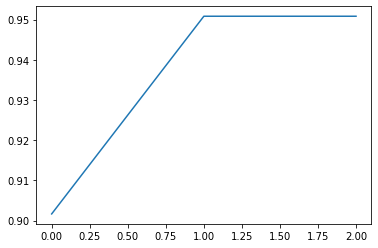

Time taken for fine-tuning: 00:01:04.78
Classifying sentences...


100%|██████████| 203/203 [00:04<00:00, 44.51it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.000s...
[t-SNE] Computed neighbors for 203 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 11.652477
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.221390
[t-SNE] KL divergence after 1000 iterations: 0.461271


100%|██████████| 203/203 [00:00<00:00, 2609.05it/s]


Evaluating predictions...
Stored confusion matrix: /content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/                                BinaryClassificationExperiments/3//SBERT_model=stsb-xlm-r-multilingual_test-perc=0.15_n-epoch=10_cm.png


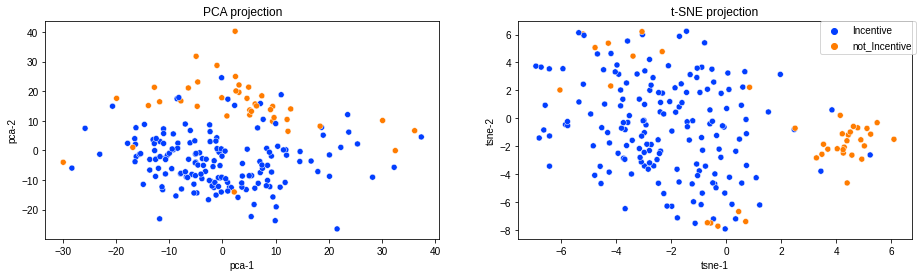

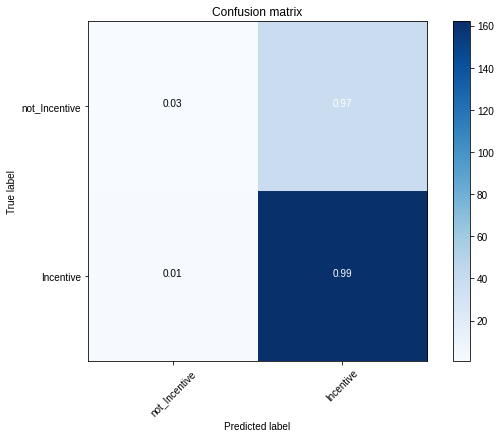

Macro/Weighted Avg F1-score: [0.46886446886446886, 0.7282520435229796]


In [8]:
grid_search_params = {
    "all_test_perc": [0.15],# 0.2,# 0.25, 0.3],
    "model_names": ['stsb-xlm-r-multilingual'],# 'paraphrase-xlm-r-multilingual-v1'],# 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "experiment": GLOBAL_EXPERIMENT_NUMBER,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5

}

grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names)

## Loading saved model

In [ ]:
"""
loading saved model from results_save_path
"""

saved_model = SentenceTransformer(model_name_or_path=results_save_path)

dir(saved_model)

SentenceTransformer(
  (0): Transformer(
    (auto_model): XLMRobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=7

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [ ]:
# clf = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=69420)

# clf = svm.SVC(gamma=0.001, C=100.)

# clf = RandomForestClassifier(n_estimators=500,
#                             max_features=0.06,
#                             n_jobs=6,
#                             random_state=69420)